## Exercises

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
def cutoff_analysis(y_test: pd.Series, y_test_hat: pd.Series, cost_matrix: np.array = np.array([[0,0],[0,0]]) ) -> list:
    """
    Calculate accuracy vector for cutoff thresholds between 0 and 1 for given true labels `y_test` 
    and predicted labels `y_test_hat`. If `cost_matrix` is specified, calculates cost vector instead.
    """
    cutoff_range = np.arange(0, 1.0, 0.01)
    vec = []
    for cutoff in cutoff_range:
        y_test_hat_bin = np.where(y_test_hat >= cutoff, 1, 0)
        conf_mat = confusion_matrix(y_test, y_test_hat_bin)
        #no cost matrix, calculate accuracy
        if np.sum(cost_matrix) == 0:
            vec.append(np.sum(np.diag(conf_mat)) / np.sum(conf_mat))
        else:
            conf_const_mat = np.multiply(conf_mat, cost_matrix)
            vec.append(conf_const_mat.sum() / len(y_test))
    return vec

Load Iris dataset from https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv to 'iris' DataFrame

In [6]:
iris = pd.read_csv('https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv')

Code `species` column to have value 1 if iris is from _versicolor_ species and 0 otherwise

In [7]:
iris['species'] = np.where(iris['species'] == 'versicolor',1,0)

Split dataset to train and validation subsets using `train_test_split` function. Training set should have **75%** of all observations.

In [8]:
X = iris.drop('species',axis=1)
y = iris['species']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25)

Build logistic regression (with `LogisticRegression` from `sklearn`) using **Elastic-net** regularization with 0.35 L1 ratio (only one solver supports that, check [here](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression))

You can read more about **Elastic-net** [here](https://en.wikipedia.org/wiki/Elastic_net_regularization)

In [9]:
model = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.35, tol=0.01).fit(X_train,y_train)

Make classification report with `classification_report`. What is accuracy of the model?

In [10]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.96      0.81        25
           1       0.75      0.23      0.35        13

    accuracy                           0.71        38
   macro avg       0.73      0.60      0.58        38
weighted avg       0.72      0.71      0.66        38



Why accuracy is so low? If you want to know check [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html#Unsupervised-learning-example:-Iris-dimensionality) below `In[19]`. Plot shows how target classes are distributed in 2D space (which was possible due to dimensionality reduction technique PCA - note that we have 4 predictors (sepal_length/width,petal_length/width) not 2). Remember we merged setosa and virginica species - knowing that look were versicolor is on the plot.

Write function 

`plot_acc_train_vs_val(y_train, y_test, y_train_hat, y_test_hat)` 

that takes following arguments:

- y_train - array of class labels (0 or 1) for training data
- y_test - array of class labels (0 or 1) for validation data 
- y_train_hat - array of probabilities (0 to 1) for class 1 for training data
- y_test_hat - array of probabilities (0 to 1) for class 1 for validation data

and produce plot like in **Finding optimal cut-off based on ACC** subsection but for both prediction on training and validation data. 

While creating function you _can_ use code as below:

```python
    acc_t = cutoff_analysis(y_train, y_train_hat)
    acc_v = ...
    plt.figure()
    plt.xlabel("Cutoff point")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. cut-off")

    plt.plot(np.arange(0, 1.0, 0.01), acc_t)
    plt.plot(... , linestyle = ":")
    plt.plot([0, 1], [max(acc_t), max(acc_t)], color = 'gray', label = "Max ACC train= " + str(round(max(acc_t),3)) + 
             " for k = " + str(np.arange(0, 1.0, 0.01)[acc_t.index(max(acc_t))]))
    plt.plot(.....................................)
    plt.legend();
```

Then test your new function using (of course after filling placeholders):

```python
y_train_hat = model. ...
y_test_hat = model. ...
plot_acc_train_vs_val(y_train, y_test, y_train_hat, y_test_hat)
```

In [11]:
def plot_acc_train_vs_val(y_train, y_test, y_train_hat, y_test_hat):
    acc_t = cutoff_analysis(y_train, y_train_hat)
    acc_v = cutoff_analysis(y_test, y_test_hat)
    plt.figure()
    plt.xlabel("Cutoff point")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. cut-off")

    plt.plot(np.arange(0, 1.0, 0.01), acc_t)
    plt.plot(np.arange(0, 1.0, 0.01), acc_v, linestyle = ":")
    plt.plot([0, 1], [max(acc_t), max(acc_t)], color = 'gray', label = "Max ACC train= " + str(round(max(acc_t),3)) + " for k = " + str(np.arange(0, 1.0, 0.01)[acc_t.index(max(acc_t))]))
    plt.plot([0, 1], [max(acc_v), max(acc_v)], color = 'gray', linestyle = ":", label = "Max ACC val= " + str(round(max(acc_v),3)) + " for k = " + str(np.arange(0, 1.0, 0.01)[acc_v.index(max(acc_v))]))
    plt.legend();

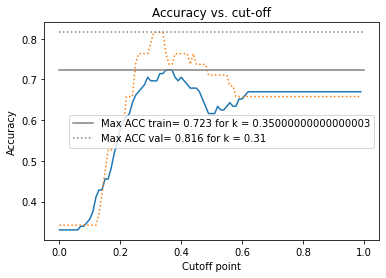

In [12]:
y_train_hat = model.predict_proba(X_train)[:,1]
y_test_hat = model.predict_proba(X_test)[:,1]
plot_acc_train_vs_val(y_train, y_test, y_train_hat, y_test_hat)

On the plot you may see that accuracy for train and validation sets prediction id quite similar. Shouldn't the accuracy be better on the training set prediction? In this case not necessarily becuase model is **underfitted** - in other words it's biased and may perform better on validation set.